# Predicting Credit Card Fraud
    Using ********** dataset to predict credit card fraud on future purchases.
    
    
## Contents
    1. Data Cleaning and Preprocessing
    2. EDA
    3. Prediction Preprocessing
    4. Modelling
    5. Evaluation

# Data Cleaning and Preprocessing

In [1]:
#Loading common libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")
random_state=13; #used throughout code to ensure consistent results when the code is rerun

In [2]:
df = pd.read_csv('D:/Desktop/Datasets/creditcard.csv')
#df.head()
print(df.columns.tolist())

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [3]:
#reorder columns into an easier to understand order
dfColumns=df.columns.tolist();
dfColumns=[dfColumns[-1]]+dfColumns[:-1];
dfColumns=[dfColumns[0]]+[dfColumns[-1]]+dfColumns[1:-1];
df=df[dfColumns];
df.head()

,Class,Amount,Time,V1,V2,V3,V4,V5,V6,V7,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,0,149.62,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,...,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053
1,0,2.69,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,...,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724
2,0,378.66,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,...,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752
3,0,123.50,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,...,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458
4,0,69.99,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,...,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153


In [4]:
#Search for missing values
print('There are',df.isna().sum().max(),'missing values in the dataframe')
print('The dataset consists of',df.shape[0],'observations')

There are 0 missing values in the dataframe
The dataset consists of 284807 observations


## Dataset Observations
    This data set is using actual customer data which was collected by the Machine Learning Group at ULB. As a way to conceal customer information, PCA was perfromed on the sensitive
    data in columns V1 to V28 by the provider of the data. The fraud prediction will relly on the following provided features (transaction amount, transaction time, and V1 to V28).
    The class column contains the labels for every observation in the dataset. This dataset doesn't require much cleaning since there are no missing values, which greatly simplifies
    the preprocessing tasks. The labels are given in binary form where 0 indicates no fraud and 1 indicates fraud. The feautre transaction time, indicates the time (seconds) the
    transaction took place in relation to the first sample in the data set.
    
    It's important to first gain an intuition into how our feature set may influenced it's given label. This can be done by simply making some observations as to how each feature could 
    affect its sample's label. Transaction amount could be significant because it tells how much is being transfered when a credit card scam is taking place. Through intuition, it
    seems more likely that credit card fraud when happen with a mdeium to large transaction amount since a scammer isn't very likely to perform a scam for a small reward. Transaction
    time may also be significant because it shows when each transaction took place in relation to each other. Credit card fraud is usually done with multiple transactions which are
    grouped together. Therefore, it seems that multiple credit card transactions happening close to each other would lead to a higher fraud risk. Finally, the feature columns V1 to V28
    don't allow us to give much insight in to what results we might expect. This severly hinders variable selection and other EDA tasks since we can't see how individual features may
    the prediction. While it isn't known, I suspect these columns consist of transaction identifiers such as credit card numbers which may help us correlate different transactions. 

By performing PCA on columns V1 to V28, we are able to confirm that PCA was performed on them because the PCA transformation of this matrix is identical to the matrix provided to it
If desired we can reduce dimensionality by taking out some of the principle components. 
The plot below shows how the usefulness of the feature the higher the principle component is. This will be experimented with further below.


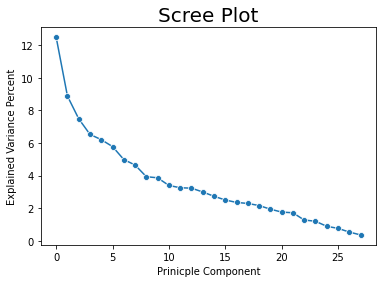

In [5]:
pca = PCA()
X_actual_pca=df.loc[:,'V1':'V28'];
X_verify_pca = pca.fit_transform(df.loc[:,'V1':'V28'])
#print(X_actual_pca.head())
#print(pd.DataFrame(X_verify_pca).head())
print('By performing PCA on columns V1 to V28, we are able to confirm that PCA was performed on them because the PCA transformation of this matrix is identical to the matrix provided to it')
print('If desired we can reduce dimensionality by taking out some of the principle components. \nThe plot below shows how the usefulness of the feature the higher the principle component is. This will be experimented with further below.')

e_var=pca.explained_variance_ratio_; #print(e_var*100)
x_plot=np.linspace(0,len(e_var)-1,num=len(e_var))

fig,ax=plt.subplots()
sns.lineplot(x=x_plot,y=e_var*100,marker="o",ax=ax)
ax.set_title('Scree Plot',fontsize=20);ax.set_xlabel('Prinicple Component');ax.set_ylabel('Explained Variance Percent');
#var_matrix=X_actual_pca.cov();cov_diag=np.diag(var_matrix);print(cov_diag[0]/np.sum(cov_diag));      Verify results of explained variance

No Fraud:  99.83 % of the dataset
Fraud:  0.17 % of the dataset


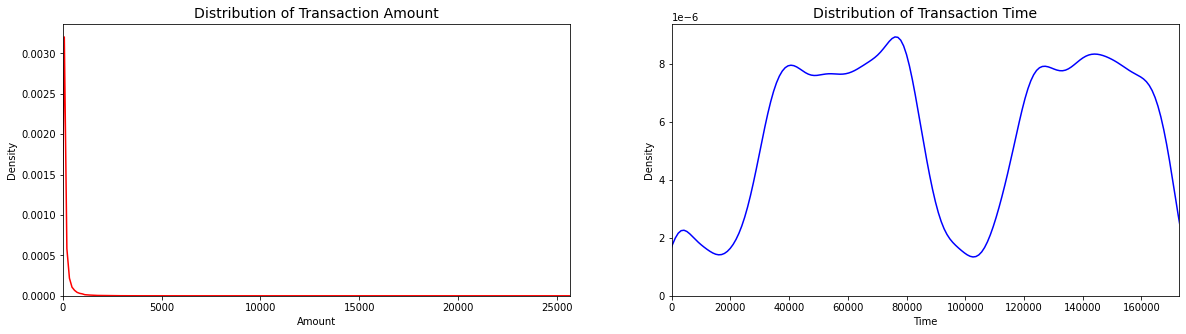

In [6]:

print('No Fraud: ',round(df['Class'].value_counts(normalize=True)[0]*100,2),'% of the dataset');
print('Fraud: ',round(df['Class'].value_counts(normalize=True)[1]*100,2),'% of the dataset');
#print(df['V1'].value_counts(normalize=True,bins=5,dropna=False)); 
fig,ax=plt.subplots(1,2,figsize=(20,5));
sns.kdeplot(df['Amount'],ax=ax[0],color='r');ax[0].set_title('Distribution of Transaction Amount',fontsize=14);ax[0].set_xlim([min(df['Amount']),max(df['Amount'])]);#ax[0].set_ylim([0,2000]);
sns.kdeplot(df['Time'],ax=ax[1],color='b');ax[1].set_title('Distribution of Transaction Time',fontsize=14);ax[1].set_xlim([min(df['Time']),max(df['Time'])]);#ax[1].set_ylim([0,10000]);
#sns.boxplot(x='Amount',data=df,ax=ax[1,0]);sns.boxplot(x='Time',data=df,ax=ax[1,1]);ax[1,0].set_title('Box Plot of Transaction Amount');ax[1,1].set_title('Box Plot of Transaction Time');


From the above observations, several key observations can be made to guide furthersteps. The x-axes are scaled to max/min feature values to show the true scale of the data.
The distribution of transaction amount has a very strong positive skew in the form of an exponential distribution. Because of this we can also conclude that it has some outliers due to this distribution. This makes sense, since a credit card isn't normally used for extremly large purchases.  

The distribution of transaction time lightly follows a bimodal distribution because of the drop in sample points with a transaction time of around 100,000 seconds.

The number of non fraud cases clearly dominates the dataset. Several different sampling techniques will be experimented with in order to improve the preiction so that it doesn't form a bias to predict towards the majority class.

In order to improve predictions we need to scale these features so that one doesn't under/over influence the prediction too much. Our feature set consists of feautures v1 to v28,transaction time, and transaction amount. Features V1 to V28 were transformed as a result of PCA, therefore they are all standardized already. We will used the robustscaler since it is good at influencing outfliers which are affecting the transaction amount feature. It does this by scaling in relation to the IQR

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
rob_scaler=RobustScaler();
UnscaledAmount=df['Amount'];Unscaledtime=df['Time'];
df['Scaled_Amount']= rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Scaled_Time']=rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time','Amount'],axis=1,inplace=True)           #now put them at the front of the df
ScaledAmount=df['Scaled_Amount'];ScaledTime=df['Scaled_Time'];df.drop(['Scaled_Amount','Scaled_Time'],axis=1,inplace=True);
df.insert(1,'Scaled_Amount',ScaledAmount);df.insert(2,'Scaled_Time',ScaledTime);
print(df.head())


   Class  Scaled_Amount  Scaled_Time        V1        V2        V3        V4  \
0      0       1.783274    -0.994983 -1.359807 -0.072781  2.536347  1.378155   
1      0      -0.269825    -0.994983  1.191857  0.266151  0.166480  0.448154   
2      0       4.983721    -0.994972 -1.358354 -1.340163  1.773209  0.379780   
3      0       1.418291    -0.994972 -0.966272 -0.185226  1.792993 -0.863291   
4      0       0.670579    -0.994960 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7  ...       V19       V20       V21       V22  \
0 -0.338321  0.462388  0.239599  ...  0.403993  0.251412 -0.018307  0.277838   
1  0.060018 -0.082361 -0.078803  ... -0.145783 -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  ... -2.261857  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  ... -1.232622 -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941  ...  0.803487  0.408542 -0.009431  0.798278   

        V23       V24       V25       

The median of Transaction Amount is 22.0 when unscaled, and 0.0 unscaled
The median of Transaction Time is 84692.0 when unscaled, and 0.0 unscaled
----------------------------------------------------------------------------------------------------
As shown below, this transformation drastically reudces the vairance which increases the sample density due to the reduced variation in transaction amount and time values.
The shape of the distributions for both variables remained unchanged


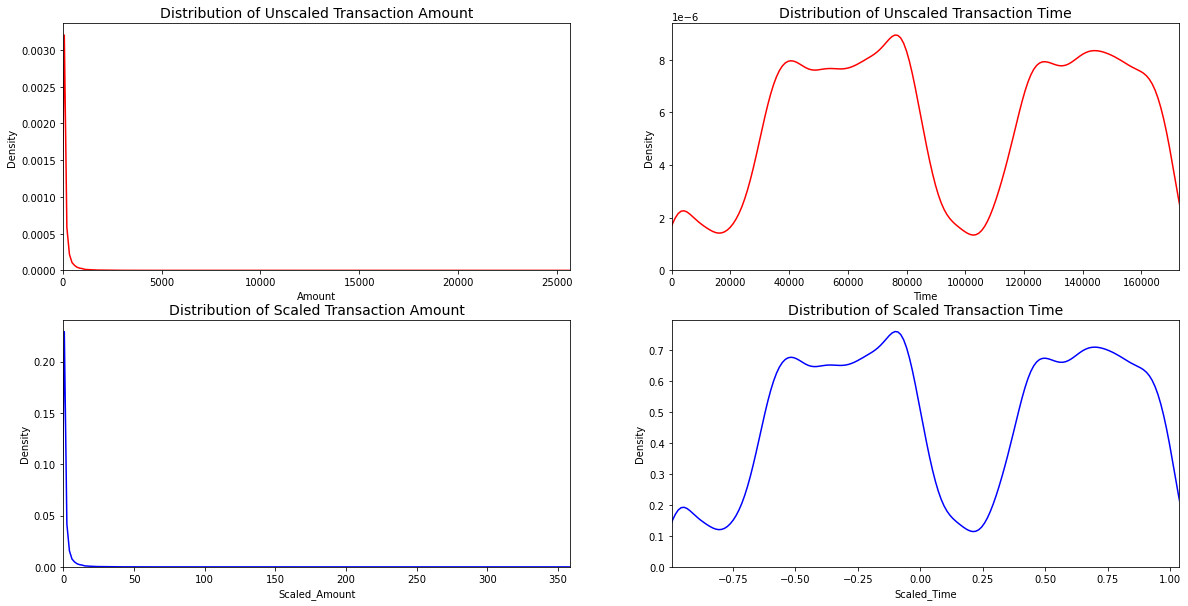

In [8]:
fig,ax=plt.subplots(2,2,figsize=(20,10));
sns.kdeplot(UnscaledAmount,ax=ax[0,0],color='r');ax[0,0].set_title('Distribution of Unscaled Transaction Amount',fontsize=14);ax[0,0].set_xlim([min(UnscaledAmount),max(UnscaledAmount)]);#ax[0].set_ylim([0,2000]);
sns.kdeplot(df['Scaled_Amount'],ax=ax[1,0],color='b');ax[1,0].set_title('Distribution of Scaled Transaction Amount',fontsize=14);ax[1,0].set_xlim([min(df['Scaled_Amount']),max(df['Scaled_Amount'])]);

sns.kdeplot(Unscaledtime,ax=ax[0,1],color='r');ax[0,1].set_title('Distribution of Unscaled Transaction Time',fontsize=14);ax[0,1].set_xlim([min(Unscaledtime),max(Unscaledtime)]);#ax[0].set_ylim([0,2000]);
sns.kdeplot(df['Scaled_Time'],ax=ax[1,1],color='b');ax[1,1].set_title('Distribution of Scaled Transaction Time',fontsize=14);ax[1,1].set_xlim([min(df['Scaled_Time']),max(df['Scaled_Time'])]);

print('The median of Transaction Amount is',np.median(UnscaledAmount),'when unscaled, and',np.median(df['Scaled_Amount']),'unscaled');
print('The median of Transaction Time is',np.median(Unscaledtime),'when unscaled, and',np.median(df['Scaled_Time']),'unscaled');
print('-'*100)
print('As shown below, this transformation drastically reudces the vairance which increases the sample density due to the reduced variation in transaction amount and time values.\nThe shape of the distributions for both variables remained unchanged');

In [9]:
#also want to create as sub-sample of df to partally get rid of inbalnce. In the sub sample we will use all the fraud examples and an equal number of random non fraud examples (492 cases) (RANDOM UNDERSAMPLING)
#Overfitting: models will assume that in most cases there are no frauds, want our model to be certain when a fraud occurs.
#Wrong Correlations: don't know what the "V" features stand for, it will be useful to understand how each of these features influence the result (imbalanced dataframe cant see the true correlations between the class and features.)

#first perform a simple train/test split before going further to ensure there is no data leakage to the test set
#from there we will experiment with different sampling techniques
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
df=df.sample(frac=1,random_state=random_state); #shuffle dataset before split
X=df.drop('Class',axis=1);y=df['Class'];

#Use stratified kfold to ensure we have equal class distribution in each split
fold=StratifiedKFold(n_splits=5,random_state=random_state);
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state);

#The sampling techniques will be performed on the training set while the test set is left untouched in order to provide will do the undersampling on only the training set and then test on the original dataset
# See if both the train and test label distribution are similarly distributed
training_set_label, training_set_counts = np.unique(ytrain, return_counts=True);
test_set_label, test_set_counts=np.unique(ytest, return_counts=True);
print('-'*100);
print('Label Distributions ([No Fraud (0)  Fraud (1)]):');
print('Training Set:',np.round(training_set_counts/len(ytrain),4));print('Test Set:',np.round(test_set_counts/len(ytest),4));
print('This shows that 0\'s and 1\'s take up a similar percentage of both the train and test set.\nThe stratified split worked because both sets of data have the same distribution as the whole set.' );

----------------------------------------------------------------------------------------------------
Label Distributions ([No Fraud (0)  Fraud (1)]):
Training Set: [0.9983 0.0017]
Test Set: [0.9983 0.0017]
This shows that 0's and 1's take up a similar percentage of both the train and test set.
The stratified split worked because both sets of data have the same distribution as the whole set.


No Fraud:  50.0 % of the dataset
Fraud:  50.0 % of the dataset
The randomly undersampled dataset consists of 984 samples. 492 are fraud cases and 492 samples are non fraud cases.


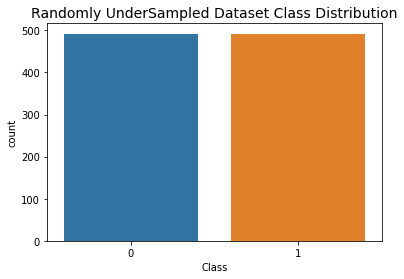

In [10]:
#start with random undersampling since we have train/test set established. This balanced dataset will give us the ability to accurately build a correlation matrix since only a balanced dataset will give accurate correlations
#to see how features are correlated. We will experiemnt with other sampling techniques later on when building models for prediction.(issue with significant undersampling is information loss)
df_FraudSamples=df.loc[df['Class']==1];NumSamples_Frauddf=df_FraudSamples.shape[0];df_NonFraudSamples=df.loc[df['Class']==0][:NumSamples_Frauddf];    #we index the non fraud df to contain the same number of samples as the fraud df so there is a 50/50 split
df_UnderSample=pd.concat([df_FraudSamples,df_NonFraudSamples]); df_UnderSample=df_UnderSample.sample(frac=1,random_state=random_state);
print('No Fraud: ',round(df_UnderSample['Class'].value_counts(normalize=True)[0]*100,2),'% of the dataset');
print('Fraud: ',round(df_UnderSample['Class'].value_counts(normalize=True)[1]*100,2),'% of the dataset');
print('The randomly undersampled dataset consists of',df_UnderSample.shape[0],'samples.',NumSamples_Frauddf,'are fraud cases and',df_NonFraudSamples.shape[0],'samples are non fraud cases.');
plt.figure();sns.countplot(df_UnderSample['Class']);plt.title('Randomly UnderSampled Dataset Class Distribution',fontsize=14);

From this correlation heatmap we can make key observations about how our predictors are correlated to the predicted variable class. We can also see how the predictors are correlated to each other,
this is important for determining if multicollinearity is an issue when building the model. 
Time,V3,V4,V10,V11,V12,and V14 have the highest correlations with the predicted class variable. This indicates that they may have the most impact in predicting the class. For a postive correlation, the higher the predictor is the more likely the predicted class will be fraud, and vice versa for negative correlation
When observing the distribution of the sample points for these highly correlated features, the fraud cases have a wider distribution than than the non fraud cases which might help later in prediction.
The results taken from these plots should only be used to guide further exploration since we assume the random undersample does a good enough job at showing the trends for the whole dataset an

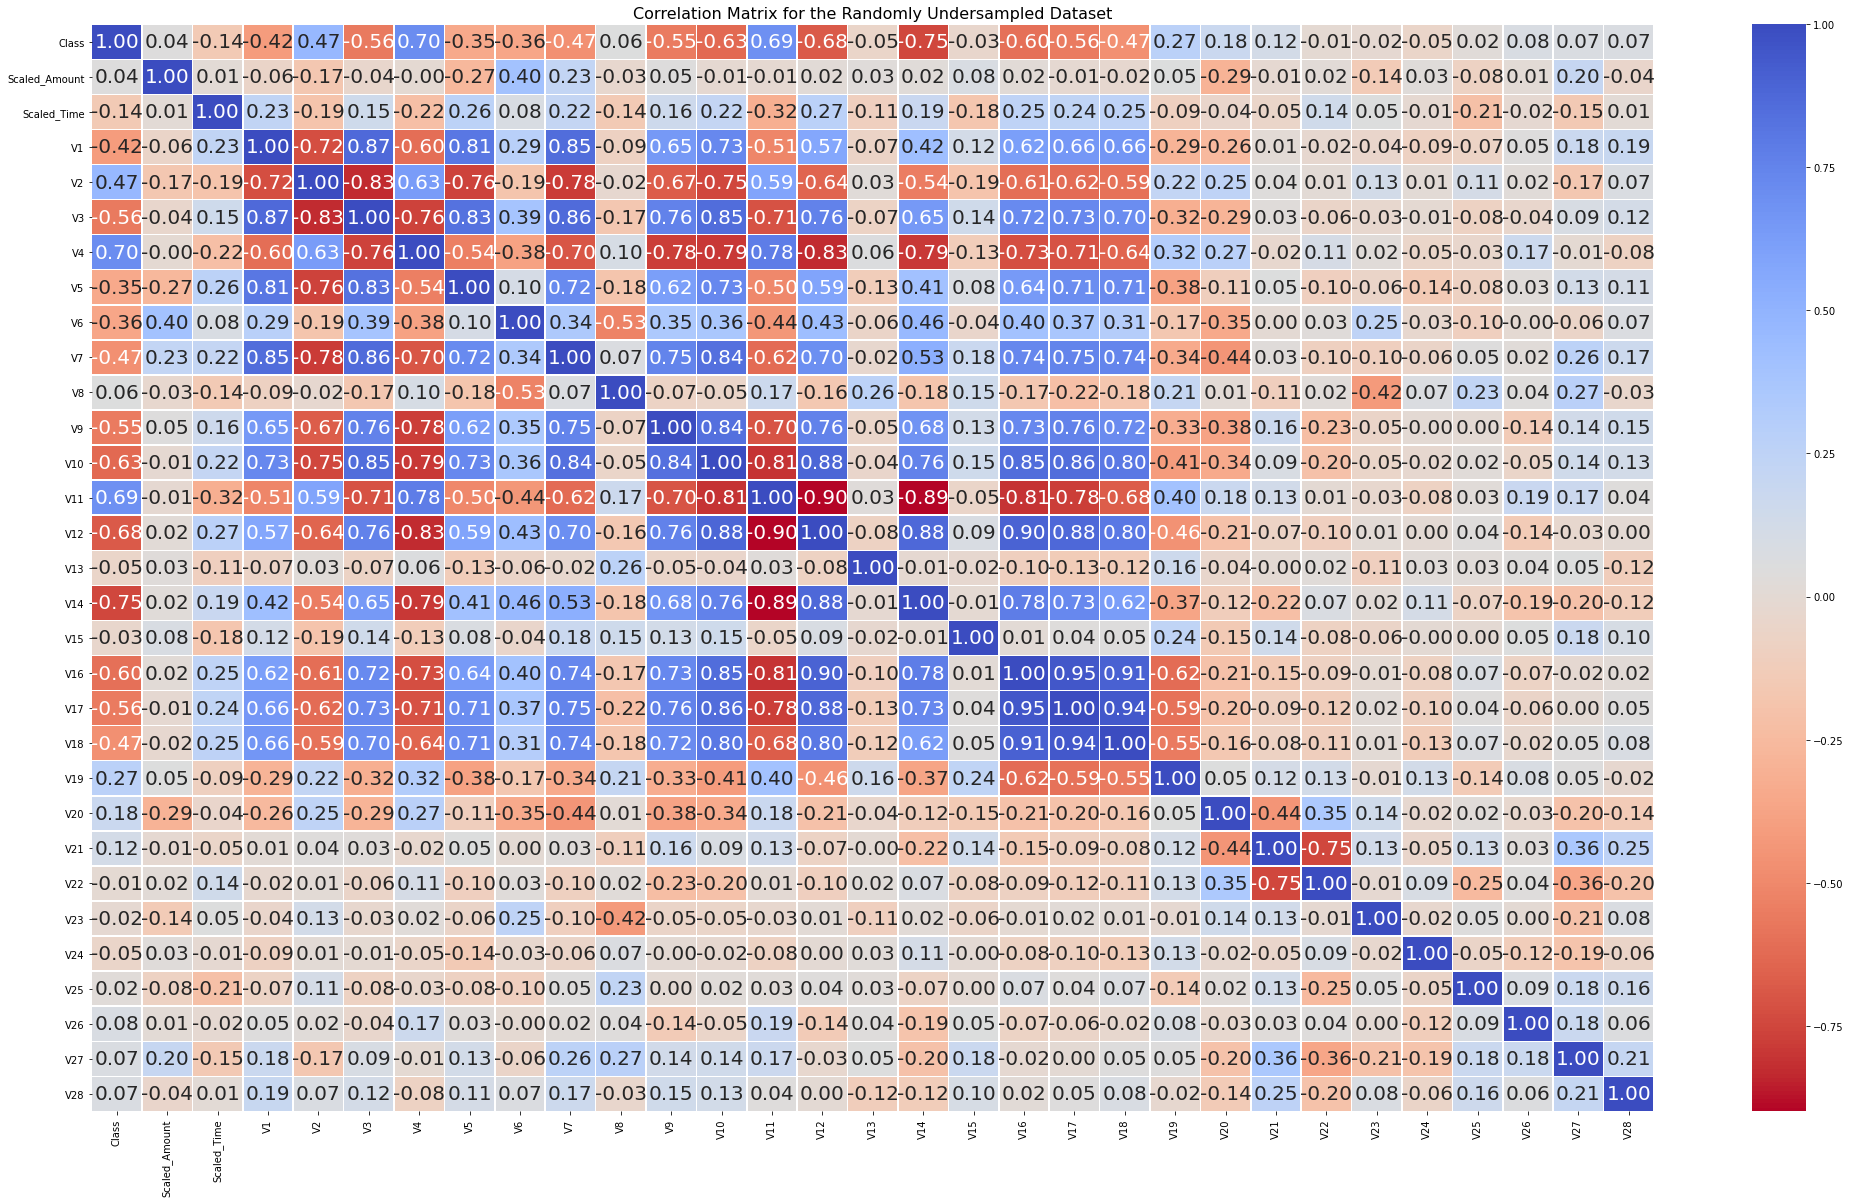

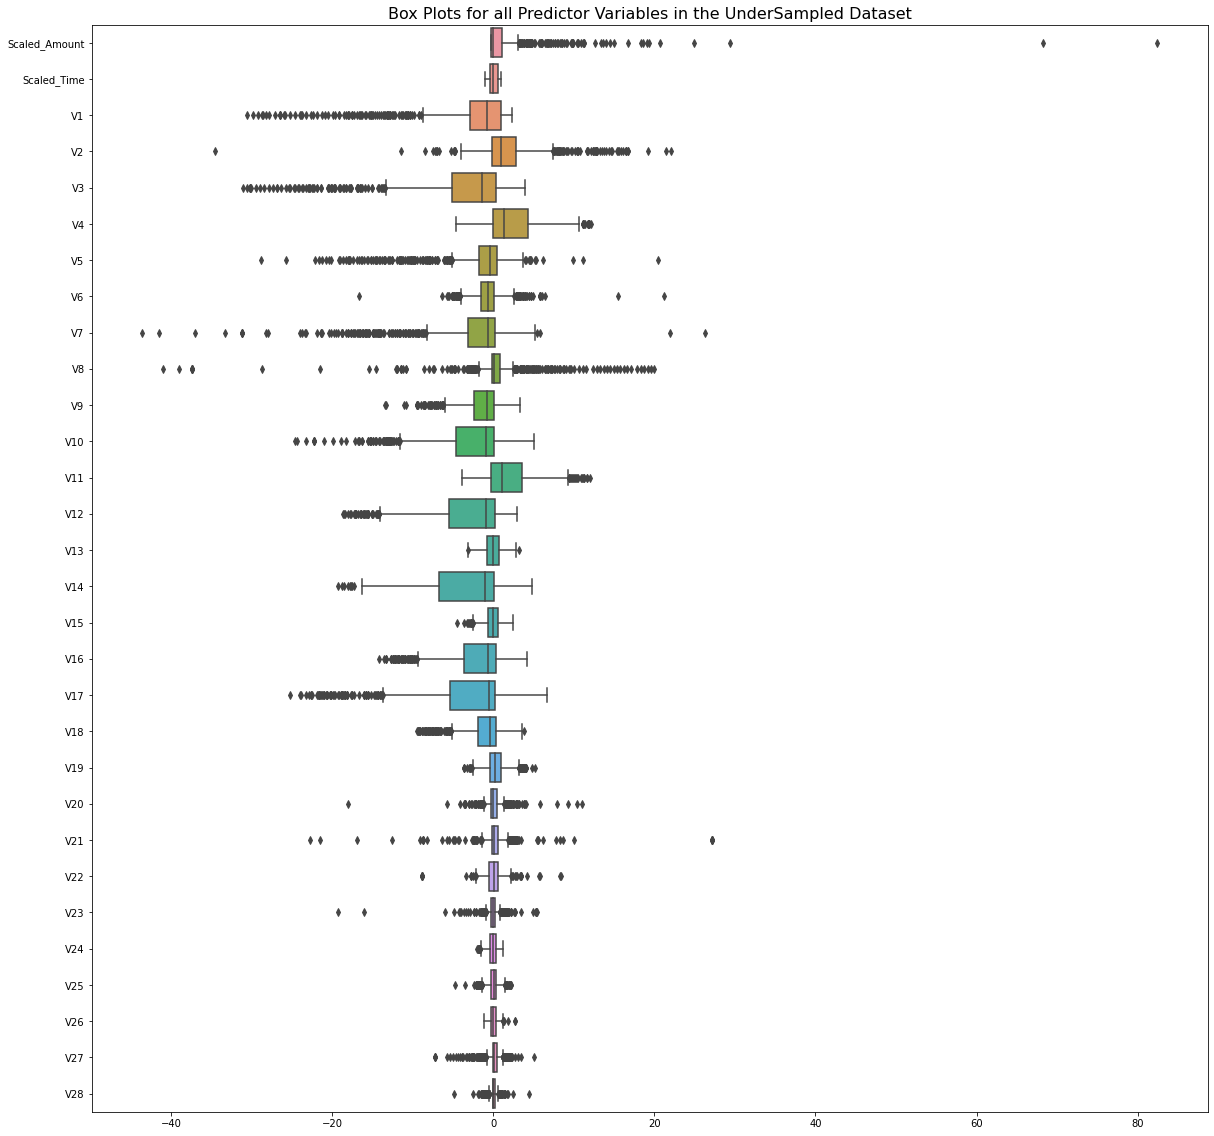

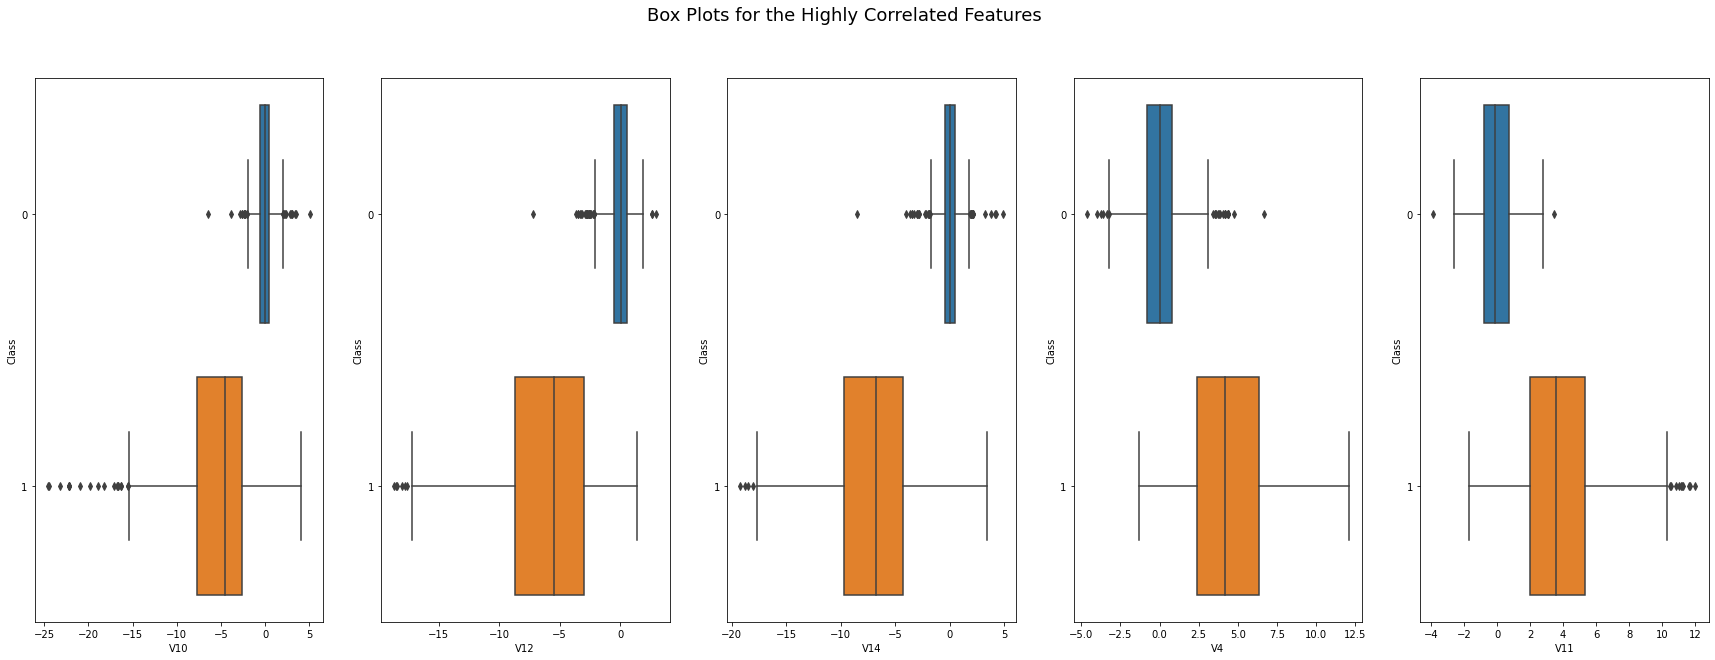

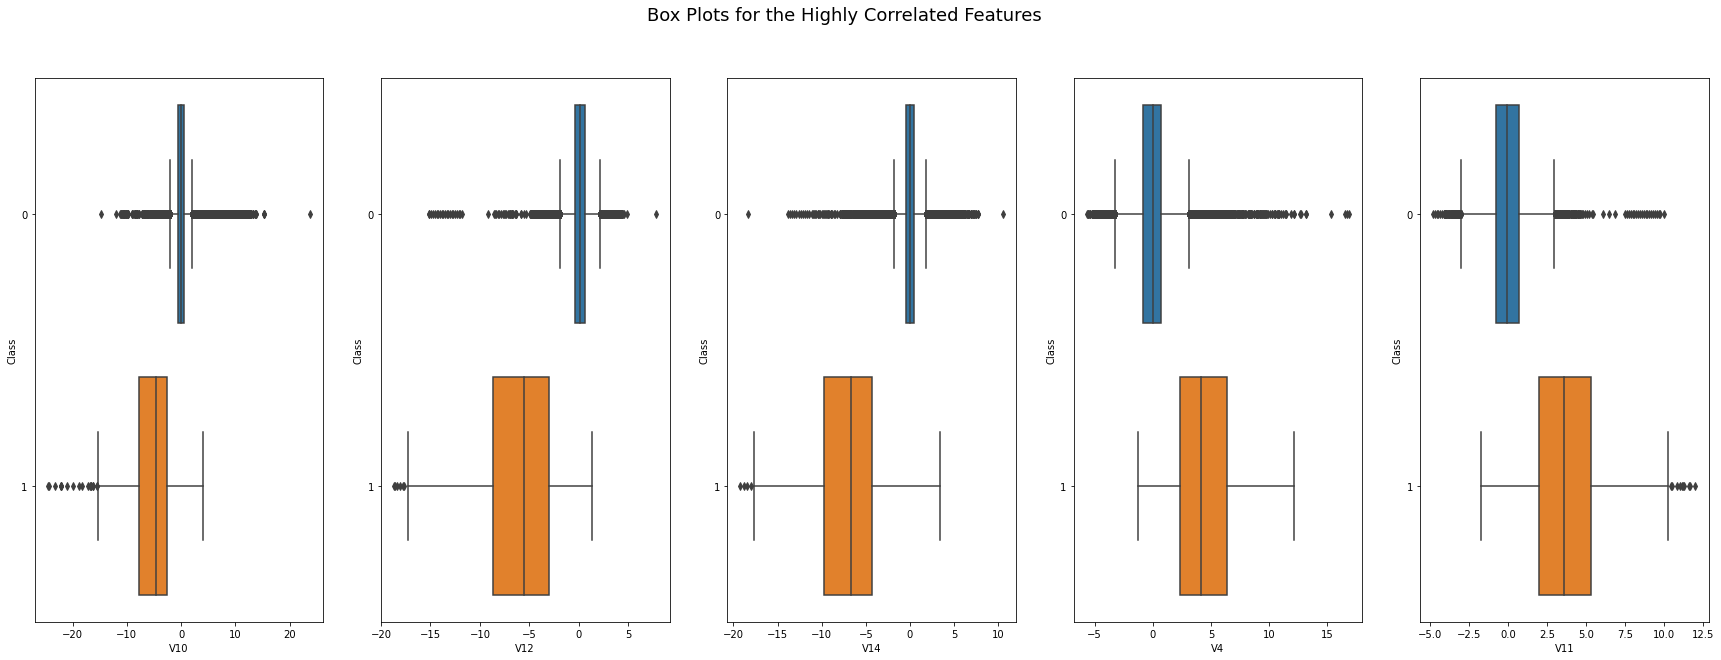

In [11]:
#corelation

#not really the best thing to use since we dont know what the v's are and these already went through PCA so they are already connected and mixed up

#Also importantly shows that  V10, V12 and V14 are negatively correlated with class. The lower these values are, the more likely there will be a fraud transaction.
#Positive Correlations: V4 and V11 are positively correlated with class. The higher these values are, the more likely there will be a fraud transaction.

#BoxPlots: We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

#it's also important to look for multicolinearity among preidctors.This isn't an issue for tree based models but is important for logistic regression

f,ax=plt.subplots(1,1,figsize=(35,20));
correlation_matrix=df_UnderSample.corr();sns.heatmap(correlation_matrix,cmap='coolwarm_r',annot=True,annot_kws={'size':20},linewidths=.5,fmt='.2f',ax=ax);ax.set_title('Correlation Matrix for the Randomly Undersampled Dataset',fontsize=16);
print('From this correlation heatmap we can make key observations about how our predictors are correlated to the predicted variable class. We can also see how the predictors are correlated to each other,\nthis is important for determining if multicollinearity is an issue when building the model. ')
print('Time,V3,V4,V10,V11,V12,and V14 have the highest correlations with the predicted class variable. This indicates that they may have the most impact in predicting the class. For a postive correlation, the higher the predictor is the more likely the predicted class will be fraud, and vice versa for negative correlation');

plt.figure(figsize=(20,20));sns.boxplot(data=df_UnderSample.drop(['Class'],axis=1), orient="h"); plt.title('Box Plots for all Predictor Variables in the UnderSampled Dataset',fontsize=16)

f,ax=plt.subplots(1,5,figsize=(30,10));plt.suptitle('Box Plots for the Highly Correlated Features',fontsize=18)
sns.boxplot(x='V10',y='Class',orient='h',data=df_UnderSample,ax=ax[0])
sns.boxplot(x='V12',y='Class',orient='h',data=df_UnderSample,ax=ax[1])
sns.boxplot(x='V14',y='Class',orient='h',data=df_UnderSample,ax=ax[2])
sns.boxplot(x='V4',y='Class',orient='h',data=df_UnderSample,ax=ax[3])
sns.boxplot(x='V11',y='Class',orient='h',data=df_UnderSample,ax=ax[4])



f,ax=plt.subplots(1,5,figsize=(30,10));plt.suptitle('Box Plots for the Highly Correlated Features',fontsize=18)
sns.boxplot(x='V10',y='Class',orient='h',data=df,ax=ax[0])
sns.boxplot(x='V12',y='Class',orient='h',data=df,ax=ax[1])
sns.boxplot(x='V14',y='Class',orient='h',data=df,ax=ax[2])
sns.boxplot(x='V4',y='Class',orient='h',data=df,ax=ax[3])
sns.boxplot(x='V11',y='Class',orient='h',data=df,ax=ax[4])

print('When observing the distribution of the sample points for these highly correlated features, the fraud cases have a wider distribution than than the non fraud cases which might help later in prediction.\nThe results taken from these plots should only be used to guide further exploration since we assume the random undersample does a good enough job at showing the trends for the whole dataset and the features with the prefix V are all connected since PCA was performed on them, therefore they are all connected ');

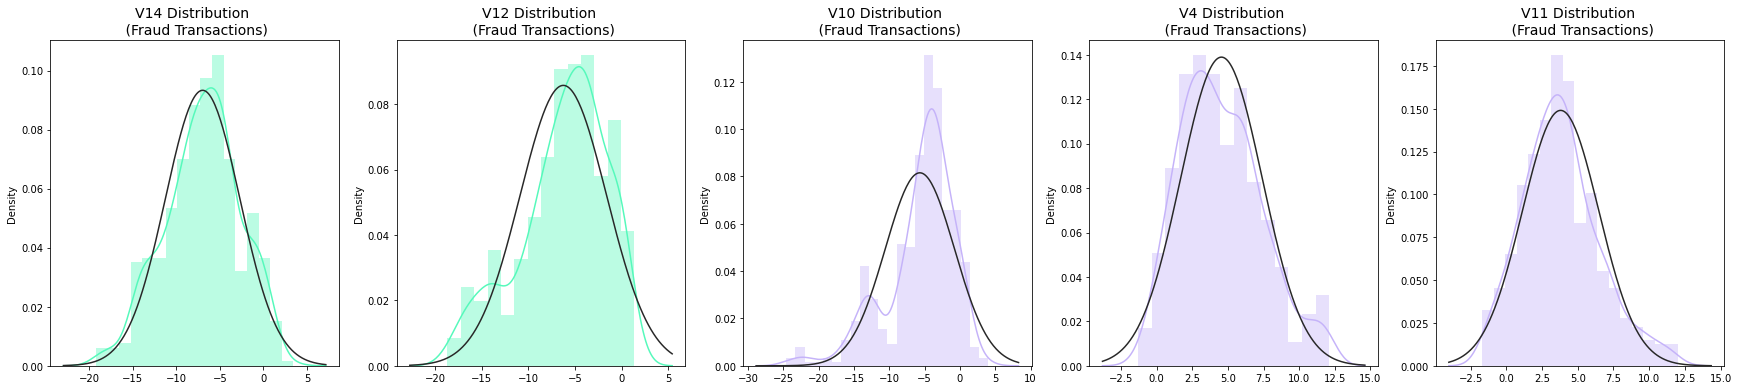

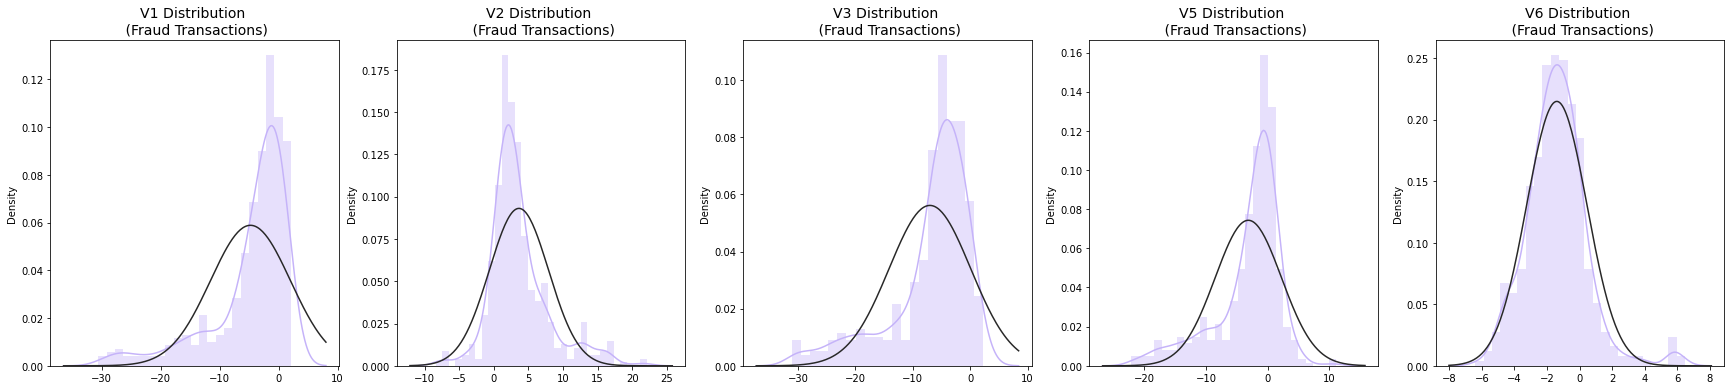

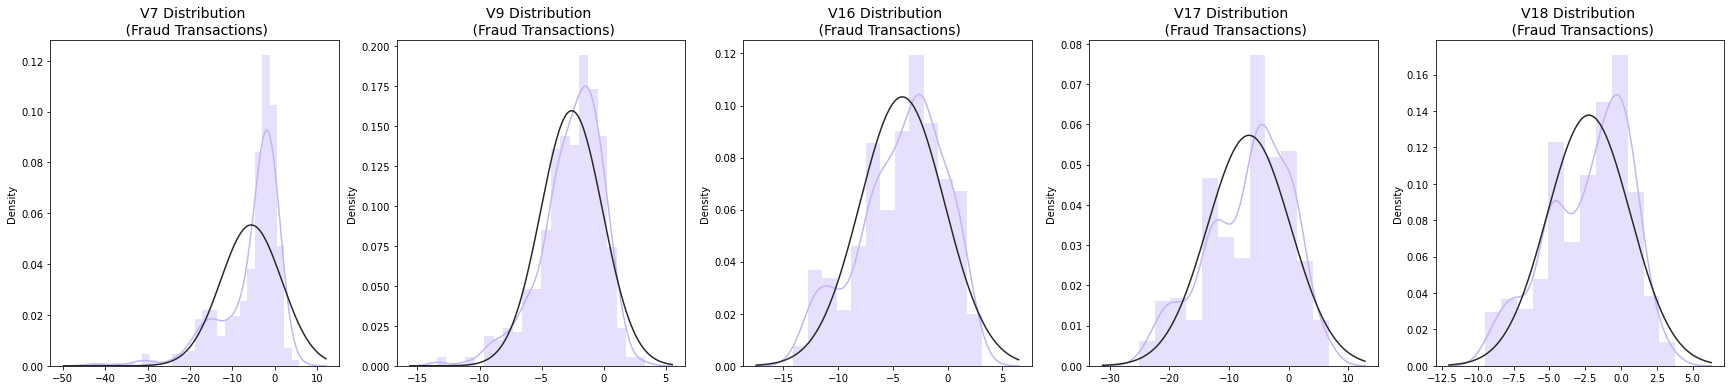

In [187]:
#Outliers (in progress)

#We will choose outliers to remove based on the Interquartile range. This is similar to what is seen in the box plots. The box represents the IQR, and the whiskers represent a threshold of 1.5*IQR
#For the distribtuions which closely follow a normal distribution, I will use the standard deviation method.

# Only fraud cases will be deleted because we are using an undersampled dataset (will expereiemnt with doing nonfraud later)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#I will perform this on all features which have a corelation greater than 0.3 (V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18)

from scipy.stats import norm
f,ax=plt.subplots(1,5,figsize=(30,6));
V14_fraud=df['V14'].loc[df['Class']==1].values;sns.distplot(V14_fraud,ax=ax[0],fit=norm,color='#56F9BB');ax[0].set_title('V14 Distribution \n (Fraud Transactions)',fontsize=14);
V12_fraud=df['V12'].loc[df['Class']==1].values;sns.distplot(V12_fraud,ax=ax[1],fit=norm,color='#56F9BB');ax[1].set_title('V12 Distribution \n (Fraud Transactions)',fontsize=14);
V10_fraud=df['V10'].loc[df['Class']==1].values;sns.distplot(V10_fraud,ax=ax[2],fit=norm,color='#C5B3F9');ax[2].set_title('V10 Distribution \n (Fraud Transactions)',fontsize=14);
V4_fraud=df['V4'].loc[df['Class']==1].values;sns.distplot(V4_fraud,ax=ax[3],fit=norm,color='#C5B3F9');ax[3].set_title('V4 Distribution \n (Fraud Transactions)',fontsize=14);
V11_fraud=df['V11'].loc[df['Class']==1].values;sns.distplot(V11_fraud,ax=ax[4],fit=norm,color='#C5B3F9');ax[4].set_title('V11 Distribution \n (Fraud Transactions)',fontsize=14);
f,ax=plt.subplots(1,5,figsize=(30,6));
V1_fraud=df['V1'].loc[df['Class']==1].values;sns.distplot(V1_fraud,ax=ax[0],fit=norm,color='#C5B3F9');ax[0].set_title('V1 Distribution \n (Fraud Transactions)',fontsize=14);
V2_fraud=df['V2'].loc[df['Class']==1].values;sns.distplot(V2_fraud,ax=ax[1],fit=norm,color='#C5B3F9');ax[1].set_title('V2 Distribution \n (Fraud Transactions)',fontsize=14);
V3_fraud=df['V3'].loc[df['Class']==1].values;sns.distplot(V3_fraud,ax=ax[2],fit=norm,color='#C5B3F9');ax[2].set_title('V3 Distribution \n (Fraud Transactions)',fontsize=14);
V5_fraud=df['V5'].loc[df['Class']==1].values;sns.distplot(V5_fraud,ax=ax[3],fit=norm,color='#C5B3F9');ax[3].set_title('V5 Distribution \n (Fraud Transactions)',fontsize=14);
V6_fraud=df['V6'].loc[df['Class']==1].values;sns.distplot(V6_fraud,ax=ax[4],fit=norm,color='#C5B3F9');ax[4].set_title('V6 Distribution \n (Fraud Transactions)',fontsize=14);
f,ax=plt.subplots(1,5,figsize=(30,6));
V7_fraud=df['V7'].loc[df['Class']==1].values;sns.distplot(V7_fraud,ax=ax[0],fit=norm,color='#C5B3F9');ax[0].set_title('V7 Distribution \n (Fraud Transactions)',fontsize=14);
V9_fraud=df['V9'].loc[df['Class']==1].values;sns.distplot(V9_fraud,ax=ax[1],fit=norm,color='#C5B3F9');ax[1].set_title('V9 Distribution \n (Fraud Transactions)',fontsize=14);
V16_fraud=df['V16'].loc[df['Class']==1].values;sns.distplot(V16_fraud,ax=ax[2],fit=norm,color='#C5B3F9');ax[2].set_title('V16 Distribution \n (Fraud Transactions)',fontsize=14);
V17_fraud=df['V17'].loc[df['Class']==1].values;sns.distplot(V17_fraud,ax=ax[3],fit=norm,color='#C5B3F9');ax[3].set_title('V17 Distribution \n (Fraud Transactions)',fontsize=14);
V18_fraud=df['V18'].loc[df['Class']==1].values;sns.distplot(V18_fraud,ax=ax[4],fit=norm,color='#C5B3F9');ax[4].set_title('V18 Distribution \n (Fraud Transactions)',fontsize=14);
'''
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14fraud=newdf['V14'].loc[newdf['Class']==1].values;q25,q75=np.percentile(v14fraud,25),np.percentile(v14fraud,75);
print('Quartile 25: {} | Quartile 75: {}'.format(q25,q75))
v14iqr=q75-q25
print('iqr: {}'.format(v14iqr))
v14cutoff=v14iqr*1.5;v14lower,v14upper=q25-v14cutoff,q75+v14cutoff;
print('Cut Off: {}'.format(v14cutoff));print('V14 Lower: {}'.format(v14lower));print('V14 Upper: {}'.format(v14upper))
outliers = [x for x in v14fraud if x < v14lower or x > v14upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)));print('V10 outliers:{}'.format(outliers))
newdf = newdf.drop(newdf[(newdf['V14'] > v14upper) | (newdf['V14'] < v14lower)].index)
print('----' * 44)
# -----> V12 removing outliers from fraud transactions
v12fraud=newdf['V12'].loc[newdf['Class']==1].values;q25,q75=np.percentile(v12fraud,25),np.percentile(v12fraud,75);
v12iqr=q75-q25;v12cutoff=v12iqr*1.5;v12lower,v12upper=q25-v12cutoff,q75+v12cutoff;
print('V12 Lower: {}'.format(v12lower));print('V12 Upper: {}'.format(v12upper))
outliers = [x for x in v12fraud if x < v12lower or x > v12upper]
print('V12 outliers: {}'.format(outliers));print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
newdf=newdf.drop(newdf[(newdf['V12'] > v12upper) | (newdf['V12'] < v12lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(newdf)));print('----' * 44)
# ----> Removing outliers V10 Feature
v10fraud=newdf['V10'].loc[newdf['Class']==1].values;q25,q75=np.percentile(v10fraud,25),np.percentile(v10fraud,75)
v10iqr=q75-q25;v10cutoff=v10iqr*1.5;v10lower,v10upper=q25-v10cutoff,q75+v10cutoff
print('V10 Lower: {}'.format(v10lower));print('V10 Upper: {}'.format(v10upper))
outliers=[x for x in v10fraud if x < v10lower or x > v10upper]
print('V10 outliers: {}'.format(outliers));print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
newdf=newdf.drop(newdf[(newdf['V10'] > v10upper) | (newdf['V10'] < v10lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(newdf)))

''';

In [ ]:
#building classifiers (undersampled set)

#from past work with large unbalanced datasets, I have found randomforests and and xgboost to be the adaptable the very accurate. They are also my personal favorites ....

#try MLP,log reg,rand for,xgboost.    A paper says that SMOTE with random Forest works best. but they didnt try the other three im trying

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, fbeta_score, average_precision_score,  roc_curve, confusion_matrix, precision_recall_curve

In [131]:
#This takes a long time to run. Output is pasted below. 

#I was able to select the SMOTE sampling method and these paramters after trying several different hyperparamters, grid search methods, feature elimination processes, and sampling methods.
#Using the below process with SMOTE oversampling gave me the best results. I will explore a couple of the different methods I experimented with later to show that they dont perform as well.

fold=StratifiedKFold(n_splits=5,random_state=random_state);
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=random_state);

RandomForest_Model = Pipeline([('sampling', SMOTE(random_state=random_state)),('classification', RandomForestClassifier(random_state=random_state))]);
MLP_Model = Pipeline([('sampling', SMOTE(random_state=random_state)),('classification', MLPClassifier(random_state=random_state))]);
XGB_Model = Pipeline([('sampling', SMOTE(random_state=random_state)),('classification', XGBClassifier(random_state=random_state))]);
LogisticRegression_Model = Pipeline([('sampling', SMOTE(random_state=random_state)),('classification', LogisticRegression(random_state=random_state))]);

RandomForest_Parameters={'classification__n_estimators':[400],'classification__max_depth':[20,50,80,None],'classification__min_samples_leaf': [1, 2, 4],'classification__min_samples_split': [2, 5, 10],'classification__max_features':['auto']};
MLP_Parameters={'classification__hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],'classification__activation': ['tanh', 'relu'],'classification__solver': ['sgd', 'adam'],'classification__alpha': [0.0001,0.001,0.01,0.05],'classification__learning_rate': ['constant','adaptive']};
XGB_Parameters={'classification__max_depth':[2,3,4,5,6,7,8,9,10],'classification__learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3],'classification__n_estimators':[100,200,250,300,350,400,500]};
LogisticRegression_Parameters={'classification__penalty': ['l1', 'l2','elasticnet'], 'classification__C': [0.0000001,0.000001,0.000005,0.00001,0.0005,0.0001, 0.001, 0.005, 0.01, 0.1, 1, 10, 100, 1000]};

f2=make_scorer(fbeta_score, beta=2, pos_label=1)

RandomForest_grid = RandomizedSearchCV(estimator = RandomForest_Model, param_distributions=RandomForest_Parameters, scoring=f2, cv=fold, n_jobs=-1, n_iter=10, return_train_score=True);
MLP_grid = RandomizedSearchCV(estimator = MLP_Model, param_distributions=MLP_Parameters, scoring=f2, cv=fold, n_jobs=-1, n_iter=8,return_train_score=True,random_state=random_state);
XGB_grid = RandomizedSearchCV(estimator = XGB_Model, param_distributions=XGB_Parameters, scoring=f2, cv=fold, n_jobs=-1, n_iter=10,return_train_score=True,random_state=random_state);
LogisticRegression_grid = GridSearchCV(estimator = LogisticRegression_Model, param_grid=LogisticRegression_Parameters, scoring=f2, cv=fold, n_jobs=-1, return_train_score=True);

RandomForest_grid.fit(Xtrain, ytrain);MLP_grid.fit(Xtrain, ytrain);XGB_grid.fit(Xtrain, ytrain);LogisticRegression_grid.fit(Xtrain, ytrain);

RandomForest_Estimator=RandomForest_grid.best_estimator_;MLP_Estimator=MLP_grid.best_estimator_;XGB_Estimator=XGB_grid.best_estimator_;LogisticRegression_Estimator=LogisticRegression_grid.best_estimator_

RandomForest_CVpredict = cross_val_predict(RandomForest_Estimator, Xtrain, ytrain, cv=fold, n_jobs=-1, method ='predict_proba');MLP_CVpredict = cross_val_predict(MLP_Estimator, Xtrain, ytrain, cv=fold, n_jobs=-1, method ='predict_proba');
XGB_CVpredict = cross_val_predict(XGB_Estimator, Xtrain, ytrain, cv=fold, n_jobs=-1, method ='predict_proba');LogisticRegression_CVpredict = cross_val_predict(LogisticRegression_Estimator, Xtrain, ytrain, cv=fold, n_jobs=-1, method ='predict_proba');

RandomForest_Recall=cross_val_score(RandomForest_Estimator,Xtrain,ytrain,cv=fold,scoring='recall',n_jobs=-1)
RandomForest_Precision=cross_val_score(RandomForest_Estimator,Xtrain,ytrain,cv=fold,scoring='precision',n_jobs=-1)
RandomForest_f1=cross_val_score(RandomForest_Estimator,Xtrain,ytrain,cv=fold,scoring='f1',n_jobs=-1)
RandomForest_AUC=cross_val_score(RandomForest_Estimator,Xtrain,ytrain,cv=fold,scoring='roc_auc',n_jobs=-1)
RandomForest_f2=cross_val_score(RandomForest_Estimator,Xtrain,ytrain,cv=fold,scoring=f2,n_jobs=-1)
RandomForest_prAUC=average_precision_score(ytrain, RandomForest_CVpredict[:,1])

MLP_Recall=cross_val_score(MLP_Estimator,Xtrain,ytrain,cv=fold,scoring='recall',n_jobs=-1)
MLP_Precision=cross_val_score(MLP_Estimator,Xtrain,ytrain,cv=fold,scoring='precision',n_jobs=-1)
MLP_f1=cross_val_score(MLP_Estimator,Xtrain,ytrain,cv=fold,scoring='f1',n_jobs=-1)
MLP_AUC=cross_val_score(MLP_Estimator,Xtrain,ytrain,cv=fold,scoring='roc_auc',n_jobs=-1)
MLP_f2=cross_val_score(MLP_Estimator,Xtrain,ytrain,cv=fold,scoring=f2,n_jobs=-1)
MLP_prAUC=average_precision_score(ytrain, MLP_CVpredict[:,1])

XGB_Recall=cross_val_score(XGB_Estimator,Xtrain,ytrain,cv=fold,scoring='recall',n_jobs=-1)
XGB_Precision=cross_val_score(XGB_Estimator,Xtrain,ytrain,cv=fold,scoring='precision',n_jobs=-1)
XGB_f1=cross_val_score(XGB_Estimator,Xtrain,ytrain,cv=fold,scoring='f1',n_jobs=-1)
XGB_AUC=cross_val_score(XGB_Estimator,Xtrain,ytrain,cv=fold,scoring='roc_auc',n_jobs=-1)
XGB_f2=cross_val_score(XGB_Estimator,Xtrain,ytrain,cv=fold,scoring=f2,n_jobs=-1)
XGB_prAUC=average_precision_score(ytrain, XGB_CVpredict[:,1])

LogisticRegression_Recall=cross_val_score(LogisticRegression_Estimator,Xtrain,ytrain,cv=fold,scoring='recall',n_jobs=-1)
LogisticRegression_Precision=cross_val_score(LogisticRegression_Estimator,Xtrain,ytrain,cv=fold,scoring='precision',n_jobs=-1)
LogisticRegression_f1=cross_val_score(LogisticRegression_Estimator,Xtrain,ytrain,cv=fold,scoring='f1',n_jobs=-1)
LogisticRegression_AUC=cross_val_score(LogisticRegression_Estimator,Xtrain,ytrain,cv=fold,scoring='roc_auc',n_jobs=-1)
LogisticRegression_f2=cross_val_score(LogisticRegression_Estimator,Xtrain,ytrain,cv=fold,scoring=f2,n_jobs=-1)
LogisticRegression_prAUC=average_precision_score(ytrain, LogisticRegression_CVpredict[:,1])

BestScore_RandomForest=round(RandomForest_grid.best_score_,3)
BestScore_MLP=round(MLP_grid.best_score_,3)
BestScore_XGB=round(XGB_grid.best_score_,3)
BestScore_LogisticRegression=round(LogisticRegression_grid.best_score_,3)

print('-'*75);
print('RandomForest')
print('Recall: %0.3f with a standard deviation of %0.3f' % (RandomForest_Recall.mean(), RandomForest_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (RandomForest_Precision.mean(), RandomForest_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (RandomForest_f1.mean(), RandomForest_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (RandomForest_AUC.mean(), RandomForest_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (RandomForest_f2.mean(), RandomForest_f2.std()));
print('PR AUC: %0.3f' % (RandomForest_prAUC));
print(RandomForest_Estimator)
print('F2: %0.3f' % (BestScore_RandomForest));
print('-'*75);
print('MLP')
print('Recall: %0.3f with a standard deviation of %0.3f' % (MLP_Recall.mean(), MLP_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (MLP_Precision.mean(), MLP_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (MLP_f1.mean(), MLP_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (MLP_AUC.mean(), MLP_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (MLP_f2.mean(), MLP_f2.std()));
print('PR AUC: %0.3f' % (MLP_prAUC));
print(MLP_Estimator);
print('F2: %0.3f' % (BestScore_MLP));
print('-'*75);
print('XGB')
print('Recall: %0.3f with a standard deviation of %0.3f' % (XGB_Recall.mean(), XGB_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (XGB_Precision.mean(), XGB_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (XGB_f1.mean(), XGB_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (XGB_AUC.mean(), XGB_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (XGB_f2.mean(), XGB_f2.std()));
print('PR AUC: %0.3f' % (XGB_prAUC));
print(XGB_Estimator);
print('F2: %0.3f' % (BestScore_XGB));
print('-'*75);
print('Logistic Regression')
print('Recall: %0.3f with a standard deviation of %0.3f' % (LogisticRegression_Recall.mean(), LogisticRegression_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (LogisticRegression_Precision.mean(), LogisticRegression_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (LogisticRegression_f1.mean(), LogisticRegression_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (LogisticRegression_AUC.mean(), LogisticRegression_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (LogisticRegression_f2.mean(), LogisticRegression_f2.std()));
print('PR AUC: %0.3f' % (LogisticRegression_prAUC));
print(LogisticRegression_Estimator);
print('F2: %0.3f' % (BestScore_LogisticRegression));
print('-'*75);

#here i have tried F2 score since it is good for getting labels and puts a strong influence on recall (AUC can be a bit optimistic)
#want to try this and pr AUC (roc AUC isnt as good for me)

Prediction_RandomForest=RandomForest_Estimator.predict(Xtest);
Prediction_MLP=MLP_Estimator.predict(Xtest);
Prediction_XGB=XGB_Estimator.predict(Xtest);
Prediction_LogisticRegression=LogisticRegression_Estimator.predict(Xtest);
'''
---------------------------------------------------------------------------
RandomForest
Recall: 0.813 with a standard deviation of 0.022
Precision: 0.885 with a standard deviation of 0.041
F1: 0.848 with a standard deviation of 0.027
AUC: 0.976 with a standard deviation of 0.010
F2: 0.827 with a standard deviation of 0.023
PR AUC: 0.843
Pipeline(steps=[('sampling', SMOTE(random_state=13)),
                ('classification',
                 RandomForestClassifier(max_depth=50, min_samples_leaf=2,
                                        n_estimators=400, random_state=13))])
F2: 0.827
---------------------------------------------------------------------------
MLP
Recall: 0.811 with a standard deviation of 0.006
Precision: 0.716 with a standard deviation of 0.074
F1: 0.758 with a standard deviation of 0.042
AUC: 0.952 with a standard deviation of 0.008
F2: 0.788 with a standard deviation of 0.018
PR AUC: 0.806
Pipeline(steps=[('sampling', SMOTE(random_state=13)),
                ('classification',
                 MLPClassifier(alpha=0.001, hidden_layer_sizes=(50, 100, 50),
                               random_state=13))])
F2: 0.788
---------------------------------------------------------------------------
XGB
Recall: 0.831 with a standard deviation of 0.019
Precision: 0.828 with a standard deviation of 0.035
F1: 0.829 with a standard deviation of 0.018
AUC: 0.974 with a standard deviation of 0.013
F2: 0.830 with a standard deviation of 0.015
PR AUC: 0.849
Pipeline(steps=[('sampling', SMOTE(random_state=13)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=8, num_parallel_tree=1, random_state=13,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])
F2: 0.830
---------------------------------------------------------------------------
Logistic Regression
Recall: 0.774 with a standard deviation of 0.021
Precision: 0.823 with a standard deviation of 0.019
F1: 0.797 with a standard deviation of 0.019
AUC: 0.977 with a standard deviation of 0.011
F2: 0.783 with a standard deviation of 0.020
PR AUC: 0.721
Pipeline(steps=[('sampling', SMOTE(random_state=13)),
                ('classification',
                 LogisticRegression(C=1e-07, random_state=13))])
F2: 0.783
---------------------------------------------------------------------------
''';

[03:07:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
---------------------------------------------------------------------------
RandomForest
Recall: 0.813 with a standard deviation of 0.022
Precision: 0.885 with a standard deviation of 0.041
F1: 0.848 with a standard deviation of 0.027
AUC: 0.976 with a standard deviation of 0.010
F2: 0.827 with a standard deviation of 0.023
PR AUC: 0.843
Pipeline(steps=[('sampling', SMOTE(random_state=13)),
                ('classification',
                 RandomForestClassifier(max_depth=50, min_samples_leaf=2,
                                        n_estimators=400, random_state=13))])
F2: 0.827
---------------------------------------------------------------------------
MLP
Recall: 0.811 with 

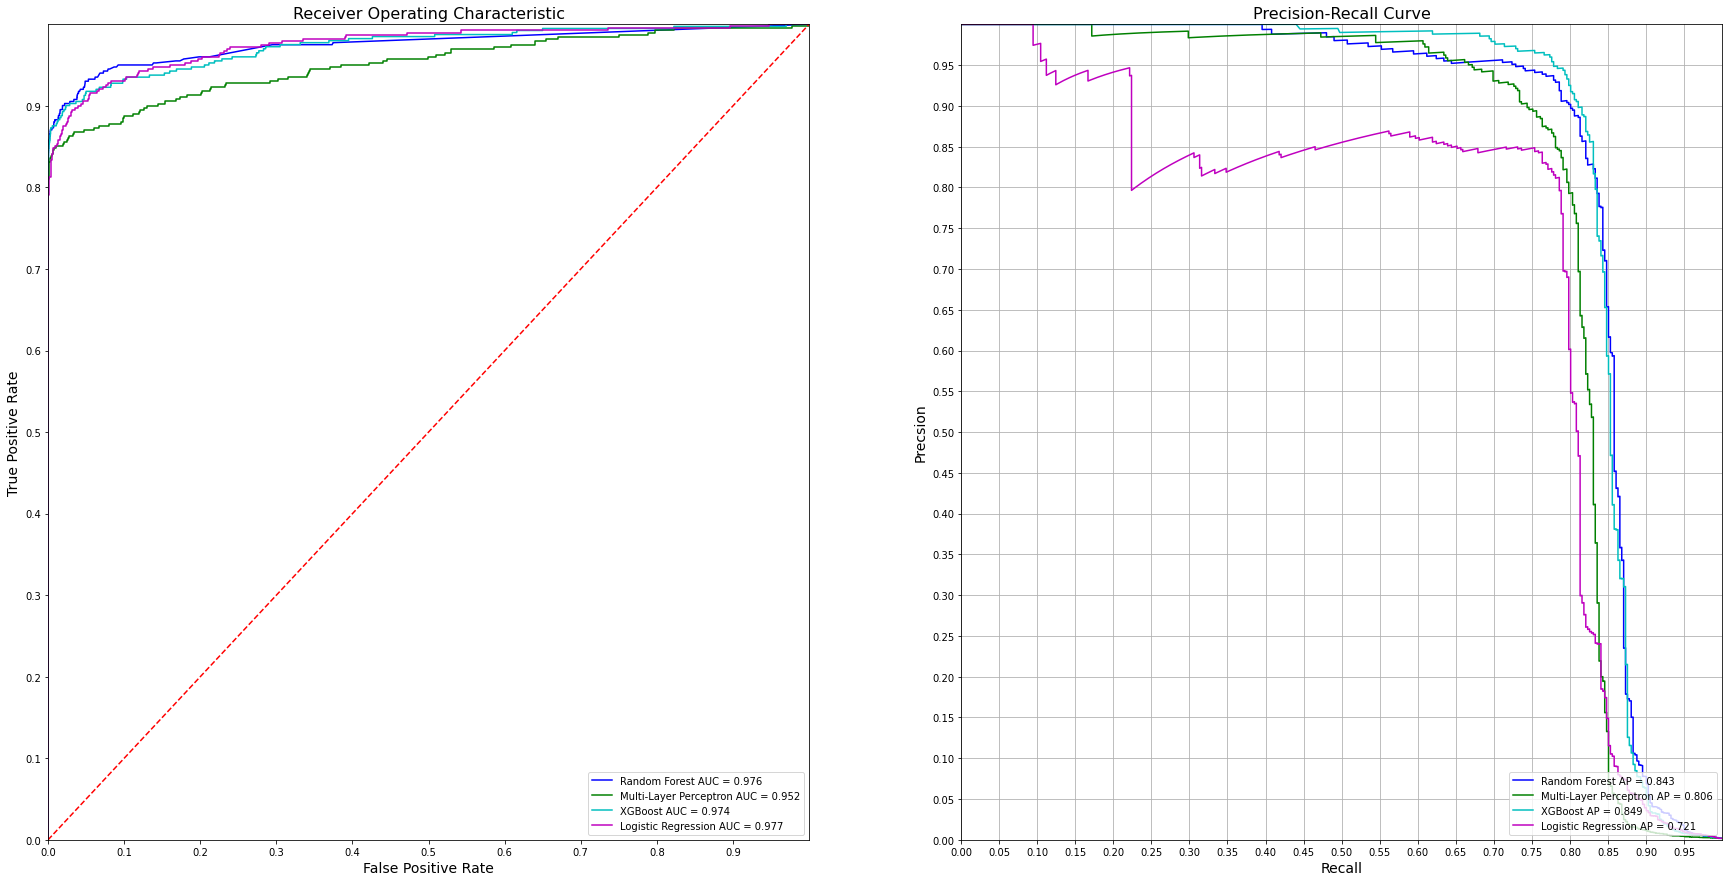

Prediction threshold to be used for desired recall-precision balance (Random Forest): 0.4107500000000001
Prediction threshold to be used for desired recall-precision balance (XGBoost): 0.5829747


In [154]:
#ROC plot for the above reduced dataset

#Train: ROC, PR
#Test: Classification reports

#TPR = recall, FPR = negative recall
#ROC
RandomForest_false_positive_rate, RandomForest_true_positive_rate, RandomForest_threshold = roc_curve(ytrain, RandomForest_CVpredict[:,1]);
MLP_false_positive_rate, MLP_true_positive_rate, MLP_threshold = roc_curve(ytrain, MLP_CVpredict[:,1]);
XGB_false_positive_rate, XGB_true_positive_rate, XGB_threshold = roc_curve(ytrain, XGB_CVpredict[:,1]);
LogisticRegression_false_positive_rate, LogisticRegression_true_positive_rate, LogisticRegression_threshold = roc_curve(ytrain, LogisticRegression_CVpredict[:,1]);
fig,ax=plt.subplots(1,2,figsize=(30,15));
ax[0].plot(RandomForest_false_positive_rate, RandomForest_true_positive_rate, 'b', label = 'Random Forest AUC = %0.3f' % RandomForest_AUC.mean());
ax[0].plot(MLP_false_positive_rate, MLP_true_positive_rate, 'g', label = 'Multi-Layer Perceptron AUC = %0.3f' % MLP_AUC.mean());
ax[0].plot(XGB_false_positive_rate, XGB_true_positive_rate, 'c', label = 'XGBoost AUC = %0.3f' % XGB_AUC.mean());
ax[0].plot(LogisticRegression_false_positive_rate, LogisticRegression_true_positive_rate, 'm', label = 'Logistic Regression AUC = %0.3f' % LogisticRegression_AUC.mean());
ax[0].legend(loc = 'lower right');
ax[0].plot([0, 1], [0, 1],'r--');
ax[0].set_xlim([0, 1]);ax[0].set_ylim([0, 1]);
ax[0].set_title('Receiver Operating Characteristic',fontsize=16);
ax[0].set_ylabel('True Positive Rate',fontsize=14);
ax[0].set_xlabel('False Positive Rate',fontsize=14);
ax[0].set_xticks(np.arange(0, 1, step=0.1));
ax[0].set_yticks(np.arange(0, 1, step=0.1));

#PR Curve
RandomForest_PR_precision, RandomForest_PR_recall, RandomForest_threshold_PR = precision_recall_curve(ytrain, RandomForest_CVpredict[:,1]);
MLP_PR_precision, MLP_PR_recall, MLP_threshold_PR = precision_recall_curve(ytrain, MLP_CVpredict[:,1]);
XGB_PR_precision, XGB_PR_recall, XGB_threshold_PR = precision_recall_curve(ytrain, XGB_CVpredict[:,1]);
LogisticRegression_PR_precision, LogisticRegression_PR_recall, LogisticRegression_threshold_PR = precision_recall_curve(ytrain, LogisticRegression_CVpredict[:,1]);
ax[1].plot(RandomForest_PR_recall, RandomForest_PR_precision, 'b', label = 'Random Forest AP = %0.3f' % RandomForest_prAUC.mean());
ax[1].plot(MLP_PR_recall, MLP_PR_precision, 'g', label = 'Multi-Layer Perceptron AP = %0.3f' % MLP_prAUC.mean());
ax[1].plot(XGB_PR_recall, XGB_PR_precision, 'c', label = 'XGBoost AP = %0.3f' % XGB_prAUC.mean());
ax[1].plot(LogisticRegression_PR_recall, LogisticRegression_PR_precision, 'm', label = 'Logistic Regression AP = %0.3f' % LogisticRegression_prAUC.mean());
ax[1].legend(loc = 'lower right');
#ax[1].plot([0, 1], [0, 1],'r--');
ax[1].set_xlim([0, 1]);ax[1].set_ylim([0, 1]);
ax[1].set_title('Precision-Recall Curve',fontsize=16);
ax[1].set_ylabel('Precsion',fontsize=14);
ax[1].set_xlabel('Recall',fontsize=14);
ax[1].set_xticks(np.arange(0, 1, step=0.05));
ax[1].set_yticks(np.arange(0, 1, step=0.05));
ax[1].grid(True)
plt.show();

#Determine desired prediction threshold from looking at the above PR plot (will be used in test set final predictions/metrics)
for i in range(len(RandomForest_threshold_PR)):
    if RandomForest_PR_precision[i]>=0.85:
        Train_prediction_threshold_RandomForest=RandomForest_threshold_PR[i];
        break
print('Prediction threshold to be used for desired recall-precision balance (Random Forest):',Train_prediction_threshold_RandomForest)
for i in range(len(XGB_threshold_PR)):
    if XGB_PR_precision[i]>=0.85:
        Train_prediction_threshold_XGB=XGB_threshold_PR[i];
        break
print('Prediction threshold to be used for desired recall-precision balance (XGBoost):',Train_prediction_threshold_XGB)

#TOMORROW: FINISH OUTLIER STUFF, TRY TO DEFINE FINAL MODEL (LOOK INTO FEATURE SELECTION STUFF)
#should also show how undersample (nearmiss) and the full model are not as good as the model with feature selection
#INCREASE NUMBER OF FEATURES IN RF MODEL, HOW WILL i DO THIS TO COMPARE TO OTHER MODELS. RUN THE LARGE RF WHILE I WORK

#pick the best model. use this mmodel to do nearmiss() and full data set to show this is the best

Predicting with the RandomForest took :2.5694520473480225 sec
Predicting with the XGBoost took :0.10229039192199707 sec

XGBoost is able to predict on new data much faster than the random forest can with it's selected hyperparameters.
This is because the Random Forest is using more trees to predict (bagged trees) while XGBoost is using less tress (boosted trees)
Bagged trees are not something which needs to be optimized except for performance vs computation time. This is because, at a certain point, adding more trees wont make the prediction noticeably better. Adding more bagged trees never makes a prediction wores in a Random Forest Model.
Boosted trees are something which needs to be optimized. The optimized value chosen for the highest scoring metric was half the number of trees compared to the random forest
XGBoost also selected a tree max depth of 8 which is much less than what was chosen for the XGBoost model. Each new prediction will have to go down fewer trees and those trees w

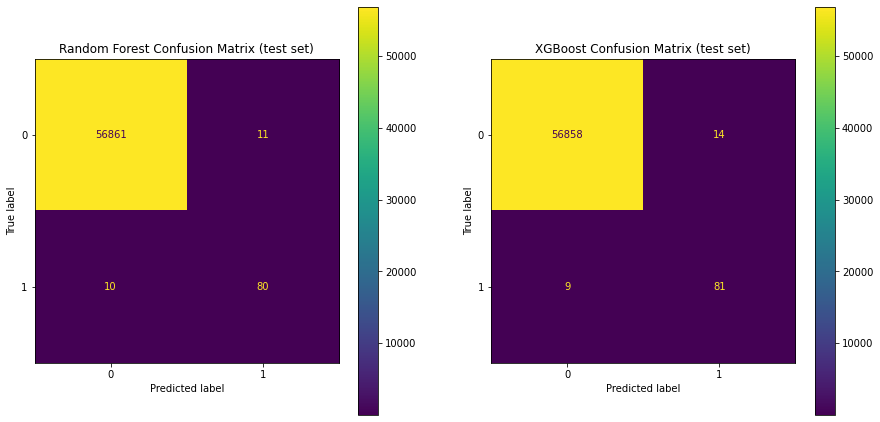

In [162]:
#ON TEST SET

#test set predictions
t0 = time.time()
Prediction_RandomForest=RandomForest_Estimator.predict(Xtest);
t1 = time.time()
Prediction_XGB=XGB_Estimator.predict(Xtest);
t2 = time.time()
print("Predicting with the RandomForest took :{} sec".format(t1 - t0))
print("Predicting with the XGBoost took :{} sec".format(t2 - t1))
print('')
print('XGBoost is able to predict on new data much faster than the random forest can with it\'s selected hyperparameters.\nThis is because the Random Forest is using more trees to predict (bagged trees) while XGBoost is using less tress (boosted trees)')
print('Bagged trees are not something which needs to be optimized except for performance vs computation time. This is because, at a certain point, adding more trees wont make the prediction noticeably better. Adding more bagged trees never makes a prediction wores in a Random Forest Model.')
print('Boosted trees are something which needs to be optimized. The optimized value chosen for the highest scoring metric was half the number of trees compared to the random forest')
print('XGBoost also selected a tree max depth of 8 which is much less than what was chosen for the XGBoost model. Each new prediction will have to go down fewer trees and those trees will have fewer levels which greatly reduces computation time')
print('As shown, XGBoost is still able to predict better than the randomforest model on this data even with the shorter coputation time.')


#Test Scoring (without threshold, below has with chosen threshold)
print('-'*50);print('TEST SET SCORES');print('-'*50);
print('Random Forest')
print('No Ajustment:')
print('Accuracy (test):',accuracy_score(ytest,Prediction_RandomForest))
print('Recall (test):',recall_score(ytest, Prediction_RandomForest))
print('Precision (test):',precision_score(ytest,Prediction_RandomForest))
print('F1 (test):',f1_score(ytest, Prediction_RandomForest))
print('F2 (test):',fbeta_score(ytest, Prediction_RandomForest, beta=2))
print('AUC (test):',roc_auc_score(ytest, Prediction_RandomForest))
print(roc_auc_score(ytest, Prediction_RandomForest))                                                      
print(classification_report(ytest,Prediction_RandomForest))
print('-'*50);
print('XGBoost')
print('No Ajustment:')
print('Accuracy (test):',accuracy_score(ytest,Prediction_XGB))
print('Recall (test):',recall_score(ytest, Prediction_XGB))
print('Precision (test):',precision_score(ytest,Prediction_XGB))
print('F1 (test):',f1_score(ytest, Prediction_XGB))
print('F2 (test):',fbeta_score(ytest, Prediction_XGB, beta=2))
print('AUC (test):',roc_auc_score(ytest, Prediction_XGB))
print(roc_auc_score(ytest, Prediction_XGB))                                                      
print(classification_report(ytest,Prediction_XGB))                                                      
                                                      
print('-'*50);print('Threshold Adjustment');print('-'*50);
Prediction_RandomForest_threshold = RandomForest_Estimator.predict_proba(Xtest)[:, 1] > 0.4
print('Random Forest')
print(accuracy_score(ytest,Prediction_RandomForest_threshold))
print(recall_score(ytest, Prediction_RandomForest_threshold))
print(precision_score(ytest,Prediction_RandomForest_threshold))
print(f1_score(ytest, Prediction_RandomForest_threshold))
print(roc_auc_score(ytest, Prediction_RandomForest_threshold))
print(classification_report(ytest,Prediction_RandomForest_threshold))
print('-'*50);print('XGBoost')
Prediction_XGB_threshold = XGB_Estimator.predict_proba(Xtest)[:, 1] > 0.6
print(accuracy_score(ytest,Prediction_XGB_threshold))
print(recall_score(ytest, Prediction_XGB_threshold))
print(precision_score(ytest,Prediction_XGB_threshold))
print(f1_score(ytest, Prediction_XGB_threshold))
print(roc_auc_score(ytest, Prediction_XGB_threshold))
print(classification_report(ytest,Prediction_XGB_threshold))
print('-'*50)
#Confusion Matrix for every predictor
fig,ax=plt.subplots(1,2,figsize=(15,7.5));
plot_confusion_matrix(RandomForest_Estimator, Xtest, ytest,ax=ax[0])
ax[0].set_title("Random Forest Confusion Matrix (test set)", fontsize=12);
plot_confusion_matrix(XGB_Estimator, Xtest, ytest,ax=ax[1])
ax[1].set_title("XGBoost Confusion Matrix (test set)", fontsize=12);

In [181]:
#testing XGBoost (final model) on the data set with some selected feature elimination and with undersampling to show how it doesn't perform as well
#Partial Models
fold=StratifiedKFold(n_splits=5,random_state=random_state);
print('Use feature importances from the previously trained XGBoost model to gather an idea of how many principal components to use. I selected to take off the last 13.')
print('This was done because they dont explain much of the variance in the data (this is shown in the scree plot above). I can only take features off the end because as the principle component increases, the less of the variance a certain feature explains')
print('')
print(XGB_Estimator.steps[1][1].feature_importances_)
Xt=X.drop(['V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28'],axis=1)

Xtrain_FeatureElimination, Xtest_FeatureElimination, ytrain_FeatureElimination, ytest_FeatureElimination = train_test_split(Xt, y, test_size=0.2, random_state=random_state);
finalmodel_parameters=XGB_grid.best_params_

#performing both of these without grid search in order to reduce computation. I will use the above selected final model

#Nearmiss Undersampling
finalmodel_undersample = Pipeline([('sampling', NearMiss()),('classification', XGBClassifier(n_estimators=200, max_depth=9, learning_rate=0.2, random_state=random_state))]);
finalmodel_undersample.fit(Xtrain, ytrain);

finalmodel_undersample_CVpredict = cross_val_predict(finalmodel_undersample, Xtrain, ytrain, cv=fold, n_jobs=-1, method ='predict_proba');

finalmodel_undersample_Recall=cross_val_score(finalmodel_undersample,Xtrain,ytrain,cv=fold,scoring='recall',n_jobs=-1)
finalmodel_undersample_Precision=cross_val_score(finalmodel_undersample,Xtrain,ytrain,cv=fold,scoring='precision',n_jobs=-1)
finalmodel_undersample_f1=cross_val_score(finalmodel_undersample,Xtrain,ytrain,cv=fold,scoring='f1',n_jobs=-1)
finalmodel_undersample_AUC=cross_val_score(finalmodel_undersample,Xtrain,ytrain,cv=fold,scoring='roc_auc',n_jobs=-1)
finalmodel_undersample_f2=cross_val_score(finalmodel_undersample,Xtrain,ytrain,cv=fold,scoring=f2,n_jobs=-1)
finalmodel_undersample_prAUC=average_precision_score(ytrain, finalmodel_undersample_CVpredict[:,1])

#Feature Elimination and SMOTE sampling
finalmodel_FeatureElimination = Pipeline([('sampling', SMOTE(random_state=random_state)),('classification', XGBClassifier(n_estimators=200, max_depth=9, learning_rate=0.2, random_state=random_state))]);
finalmodel_FeatureElimination.fit(Xtrain_FeatureElimination, ytrain_FeatureElimination);

finalmodel_FeatureElimination_CVpredict = cross_val_predict(finalmodel_FeatureElimination, Xtrain_FeatureElimination, ytrain_FeatureElimination, cv=fold, n_jobs=-1, method ='predict_proba');

finalmodel_FeatureElimination_Recall=cross_val_score(finalmodel_FeatureElimination,Xtrain_FeatureElimination,ytrain_FeatureElimination,cv=fold,scoring='recall',n_jobs=-1)
finalmodel_FeatureElimination_Precision=cross_val_score(finalmodel_FeatureElimination,Xtrain_FeatureElimination,ytrain_FeatureElimination,cv=fold,scoring='precision',n_jobs=-1)
finalmodel_FeatureElimination_f1=cross_val_score(finalmodel_FeatureElimination,Xtrain_FeatureElimination,ytrain_FeatureElimination,cv=fold,scoring='f1',n_jobs=-1)
finalmodel_FeatureElimination_AUC=cross_val_score(finalmodel_FeatureElimination,Xtrain_FeatureElimination,ytrain_FeatureElimination,cv=fold,scoring='roc_auc',n_jobs=-1)
finalmodel_FeatureElimination_f2=cross_val_score(finalmodel_FeatureElimination,Xtrain_FeatureElimination,ytrain_FeatureElimination,cv=fold,scoring=f2,n_jobs=-1)
finalmodel_FeatureElimination_prAUC=average_precision_score(ytrain_FeatureElimination, finalmodel_FeatureElimination_CVpredict[:,1])

print('-'*75);
print('Reduced dataset with Nearmiss undersampling')
print('Recall: %0.3f with a standard deviation of %0.3f' % (finalmodel_undersample_Recall.mean(), finalmodel_undersample_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (finalmodel_undersample_Precision.mean(), finalmodel_undersample_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (finalmodel_undersample_f1.mean(), finalmodel_undersample_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (finalmodel_undersample_AUC.mean(), finalmodel_undersample_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (finalmodel_undersample_f2.mean(), finalmodel_undersample_f2.std()));
print('PR AUC: %0.3f' % (finalmodel_undersample_prAUC));
print('-'*75);
print('-'*75);
print('Feature elimination and SMOTE sampling')
print('Recall: %0.3f with a standard deviation of %0.3f' % (finalmodel_FeatureElimination_Recall.mean(), finalmodel_FeatureElimination_Recall.std()));
print('Precision: %0.3f with a standard deviation of %0.3f' % (finalmodel_FeatureElimination_Precision.mean(), finalmodel_FeatureElimination_Precision.std()));
print('F1: %0.3f with a standard deviation of %0.3f' % (finalmodel_FeatureElimination_f1.mean(), finalmodel_FeatureElimination_f1.std()));
print('AUC: %0.3f with a standard deviation of %0.3f' % (finalmodel_FeatureElimination_AUC.mean(), finalmodel_FeatureElimination_AUC.std()));
print('F2: %0.3f with a standard deviation of %0.3f' % (finalmodel_FeatureElimination_f2.mean(), finalmodel_FeatureElimination_f2.std()));
print('PR AUC: %0.3f' % (finalmodel_FeatureElimination_prAUC));
print('-'*75);
Prediction_undersample=finalmodel_undersample.predict(Xtest);
Prediction_FeatureElimination=finalmodel_FeatureElimination.predict(Xtest_FeatureElimination);

#maybe try canceling out transaction amount

Use feature importances from the previously trained XGBoost model to gather an idea of how many principal components to use. I selected to take off the last 13.
This was done because they dont explain much of the variance in the data (this is shown in the scree plot above). I can only take features off the end because as the principle component increases, the less of the variance a certain feature explains

[0.01544656 0.01030918 0.00937351 0.00856289 0.01244192 0.05490924
 0.01197165 0.00866618 0.01214777 0.02977846 0.01930635 0.01809646
 0.00950217 0.01558862 0.0157186  0.6371062  0.01157581 0.00670613
 0.00700812 0.00830126 0.00680832 0.00813684 0.01075343 0.00814775
 0.01077864 0.00502512 0.00503761 0.00887066 0.00553417 0.00839031]
[14:21:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly se

--------------------------------------------------
TEST SET SCORES
--------------------------------------------------
XGBoost
No Ajustment:
Accuracy (test): 0.999403110845827
Recall (test): 0.8777777777777778
Precision (test): 0.7745098039215687
F1 (test): 0.8229166666666667
F2 (test): 0.854978354978355
AUC (test): 0.9386866804207499
0.9386866804207499
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.77      0.88      0.82        90

    accuracy                           1.00     56962
   macro avg       0.89      0.94      0.91     56962
weighted avg       1.00      1.00      1.00     56962

--------------------------------------------------
Threshold Adjustment
--------------------------------------------------
Random Forest
0.9994557775359011
0.8777777777777778
0.797979797979798
0.835978835978836
0.9387130554383333
              precision    recall  f1-score   support

           0       1.00      1.00

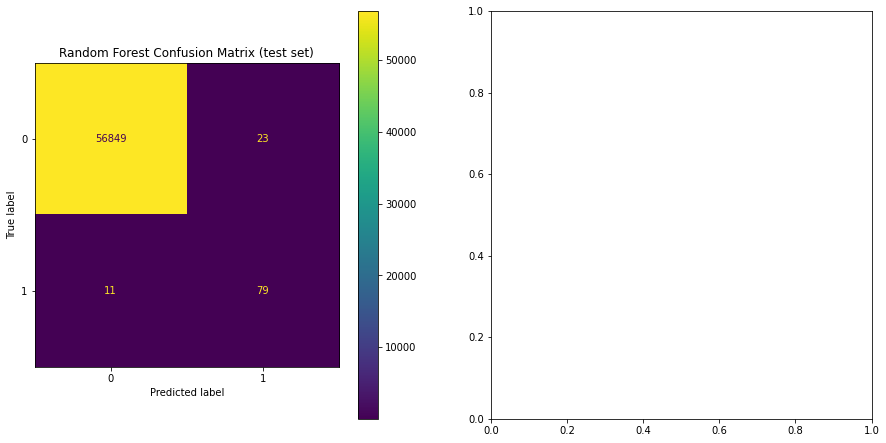

In [179]:
#Test Scoring (without threshold, below has with chosen threshold)
print('-'*50);print('Test set scores for the feature elimination model');print('-'*50);

print('No Threshold Ajustment:')
print('Accuracy (test):',accuracy_score(ytest_FeatureElimination,Prediction_FeatureElimination))
print('Recall (test):',recall_score(ytest_FeatureElimination,Prediction_FeatureElimination))
print('Precision (test):',precision_score(ytest_FeatureElimination,Prediction_FeatureElimination))
print('F1 (test):',f1_score(ytest_FeatureElimination, Prediction_FeatureElimination))
print('F2 (test):',fbeta_score(ytest_FeatureElimination, Prediction_FeatureElimination, beta=2))
print('AUC (test):',roc_auc_score(ytest_FeatureElimination, Prediction_FeatureElimination))                                                     
#print(classification_report(ytest_FeatureElimination,Prediction_FeatureElimination))                                                    
                                                      
print('Threshold Adjustment:');
Prediction_FeatureElimination_threshold = finalmodel_FeatureElimination.predict_proba(Xtest_FeatureElimination)[:, 1] > 0.6
print('Accuracy (test):',accuracy_score(ytest_FeatureElimination,Prediction_FeatureElimination_threshold))
print('Recall (test):',recall_score(ytest_FeatureElimination, Prediction_FeatureElimination_threshold))
print('Precision (test):',precision_score(ytest_FeatureElimination,Prediction_FeatureElimination_threshold))
print('F1 (test):',f1_score(ytest_FeatureElimination, Prediction_FeatureElimination_threshold))
print('F2 (test):',fbeta_score(ytest_FeatureElimination, Prediction_FeatureElimination_threshold,beta=2))
print('AUC (test):',roc_auc_score(ytest_FeatureElimination, Prediction_FeatureElimination_threshold))
#print(classification_report(ytest_FeatureElimination,Prediction_FeatureElimination_threshold))
print('-'*50);
#Confusion Matrix
fig,ax=plt.subplots(1,1,figsize=(7.5,7.5));
plot_confusion_matrix(finalmodel_FeatureElimination, Xtest_FeatureElimination, ytest_FeatureElimination,ax=ax[0])
ax[0].set_title("Random Forest Confusion Matrix (test set)", fontsize=12);


---------------------------------------------------------------------------
Final Model
---------------------------------------------------------------------------
Recall: 0.900
Precision: 0.880
F1: 0.890
F2: 0.896
ROC AUC: 0.950
---------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56872
           1       0.88      0.90      0.89        90

    accuracy                           1.00     56962
   macro avg       0.94      0.95      0.94     56962
weighted avg       1.00      1.00      1.00     56962

---------------------------------------------------------------------------
Pipeline(steps=[('sampling', SMOTE(random_state=13)),
                ('classification',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_b

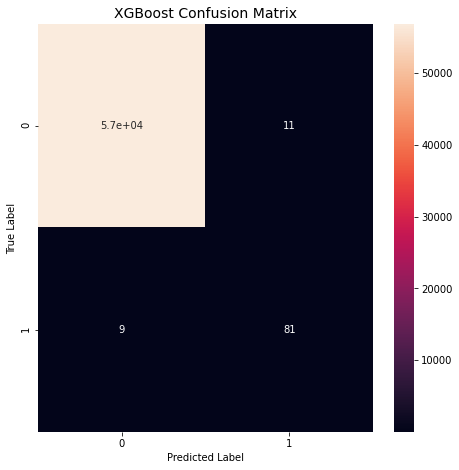

In [190]:
#Conclusion
print('-'*75);print('Final Model');print('-'*75);
finalmodel=XGB_Estimator
#print(accuracy_score(ytest,Prediction_XGB_threshold))
print('Recall: %0.3f' %(recall_score(ytest, Prediction_XGB_threshold)))
print('Precision: %0.3f' %(precision_score(ytest,Prediction_XGB_threshold)))
print('F1: %0.3f' %(f1_score(ytest, Prediction_XGB_threshold)))
print('F2: %0.3f' %(fbeta_score(ytest, Prediction_XGB_threshold,beta=2)))
print('ROC AUC: %0.3f' %(roc_auc_score(ytest, Prediction_XGB_threshold)))
print('-'*75);print('Classification Report:');print(classification_report(ytest,Prediction_XGB_threshold));
print('-'*75);print(finalmodel);print('-'*75);
finalmodel_confusionmatrix = confusion_matrix(ytest, Prediction_XGB_threshold)

fig, ax = plt.subplots(1,1,figsize=(7.5,7.5))
sns.heatmap(finalmodel_confusionmatrix, annot=True);
plt.title("XGBoost Confusion Matrix", fontsize=14);
plt.xlabel('Predicted Label');
plt.ylabel('True Label');




For furthur analysis I will attempt to build a tensorflow model (or keras? something else) to test its results

change cross val predict to cross validate with multiple scoring metrics so that computation time goes down. I did this before but was getting 1 for some reason

implement a cross validation on the test set to ensure results?? (print(np.mean(cross_val_score(rfor,org_Xtrain,org_ytrain,cv=5))))

implement extreme outlier elimination in order to improve model performance